In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys

sys.path.append("..")

from src.utils import read_yaml, read_tiff, save_yaml, fix_relative_paths
from src.metrics import evaluate_metrics, evaluate_component_metrics

import os
from os.path import dirname

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from skimage.measure import label

import yaml

from skimage.color import label2rgb
# sns.set_style("whitegrid")

In [ ]:
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.labelleft'] = False

# Leitura dos Dados

In [10]:
args = read_yaml("../args.yaml")
fix_relative_paths(args)

ROOT_PATH = dirname(dirname(os.getcwd()))
# ROOT_PATH = r"C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/"

- Leitura da imagem de satélite


In [ ]:
# Load orthoimage with 3 bands
ORTHOIMAGE = np.moveaxis( read_tiff(args.ortho_image), 0, 2)[:, :, [5,3,2]]

- Leitura da ground truth segmentation

In [6]:
TRAIN_GT_MAP = read_tiff(args.train_segmentation_path)

TEST_GT_MAP = read_tiff(args.test_segmentation_path)


- Leitura do componentes da versão 10 para cima
    - Selecionar aleatoriamente 5 amostras que não estao na ground truth segmentation


In [26]:
def square_comp_coords(comp_id, comp_map):
    coords = np.argwhere(comp_map == comp_id)

    down, top = coords[:, 0].max(),  coords[:, 0].min()

    right, left = coords[:, 1].max(),  coords[:, 1].min()

    # adding margin
    margin = 0.01

    down += int(down*margin)
    top -= int(top*margin)

    right += int(right*margin)
    left -= int(left*margin)


    #### create a square ###
    if np.abs(top-down) > np.abs(right - left):
        right = left + np.abs(top-down)

    if np.abs(top-down) < np.abs(right - left):
        down = top + np.abs(right - left)
    
    return left, right, top, down


def extract_comp_squares(comp_id, comp_map, mask_ref):
    left, right, top, down = square_comp_coords(comp_id, comp_map,)

    image = ORTHOIMAGE[top:down, left:right].copy()
    # image = image/image.max()
    image = (image - image.min()) / (image.max() - image.min())

    # mask = np.where(comp_map[top:down, left:right] > 0, 1, 0)*0.3
    mask = mask_ref[top:down, left:right]

    image[:,:, 0] += mask * 0.7
    image[:,:, 1] += mask * 0.4
    image[:,:, 2] += mask * 0.4

    return image


def add_mask(mask_ref, left, right, top, down):
    
    image = ORTHOIMAGE[top:down, left:right].copy()
    # image = image/image.max()
    image = (image - image.min()) / (np.quantile(image, 0.99) - image.min())

    # mask = np.where(comp_map[top:down, left:right] > 0, 1, 0)*0.3
    mask = mask_ref[top:down, left:right]

    image = label2rgb(mask, image,  saturation=1)
    
    return image

In [8]:
version_folders = pd.Series(os.listdir(ROOT_PATH))

version_folders = version_folders[version_folders.str.endswith("_version_data")].sort_values()

version_folders = ROOT_PATH + version_folders+"/"

# version_folders

In [9]:
np.random.seed(123)
version_images = dict()

NUM_IMAGES = 5

for version_folder in version_folders.values:

    iter_folders =  pd.Series(os.listdir(version_folder))

    iter_folders = iter_folders[iter_folders.str.startswith("iter_") & ~ iter_folders.str.endswith("000")]
    
    iter_folders = version_folder + iter_folders
    
    iter_folders = iter_folders.sort_values().tolist()
    
    iter_folders.pop()
    
    version_num = float(version_folder.split("/")[-2].replace("_version_data", ""))
    
    if version_num < 19:
        continue
    
    # Pegando apenas a última iteração
    for iter_folder in iter_folders[0:1]:
        
        num_iter = int(iter_folder[-3:])
        
        all_labels = read_tiff(os.path.join(iter_folder, "new_labels", "all_labels_set.tif"))
        all_labels = np.where(TRAIN_GT_MAP > 0, 0 , all_labels)

        all_labels_dt_map = read_tiff(os.path.join(iter_folder, "distance_map", "all_labels_distance_map.tif"))
        all_labels_dt_map = np.where(TRAIN_GT_MAP > 0, 0 , all_labels_dt_map)
        
        all_labels_dt_map = np.where(all_labels_dt_map > 0.01, 1 / (all_labels_dt_map + 0.1), all_labels_dt_map)
        all_labels_dt_map = all_labels_dt_map / np.max(all_labels_dt_map)
        

        all_labels_comp = label(all_labels)

        comp_ids = np.unique(all_labels_comp)

        random_comp = np.random.choice(comp_ids, size = NUM_IMAGES)

        version_images[version_num] =  [extract_comp_squares(comp_id, all_labels_comp, all_labels_dt_map) for comp_id in random_comp]
        
        print(iter_folder)
        
    

C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.0_version_data/iter_001
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.1_version_data/iter_001
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.2_version_data/iter_001
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.3_version_data/iter_001
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.4_version_data/iter_001



- Mostrar os recortes selecionados


# Alguns exemplos dos resultados de cada versão

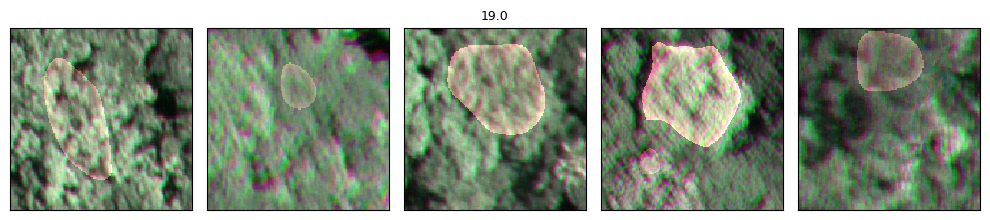

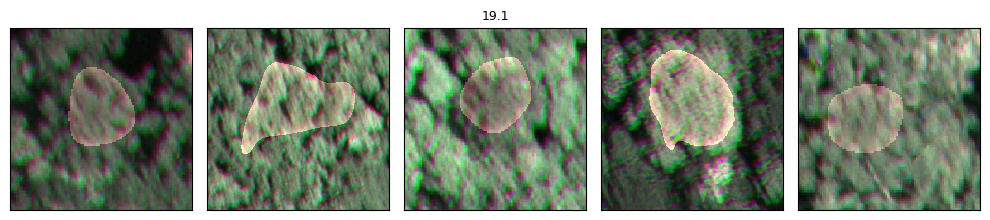

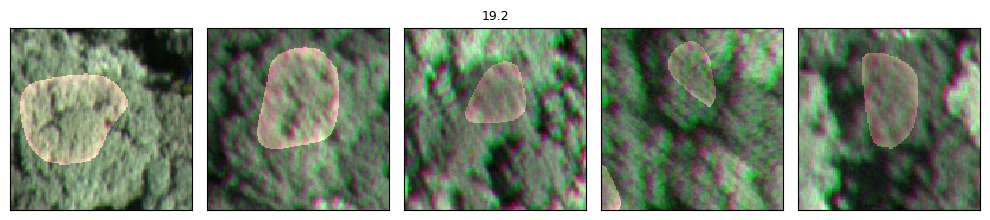

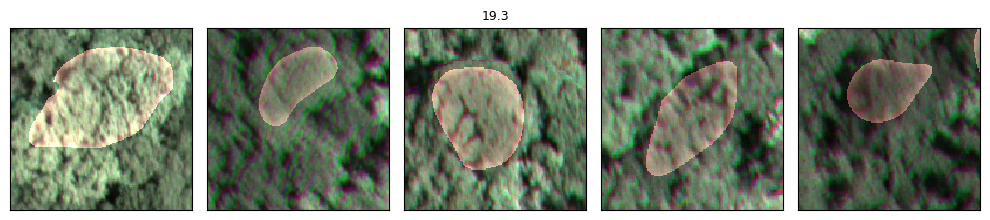

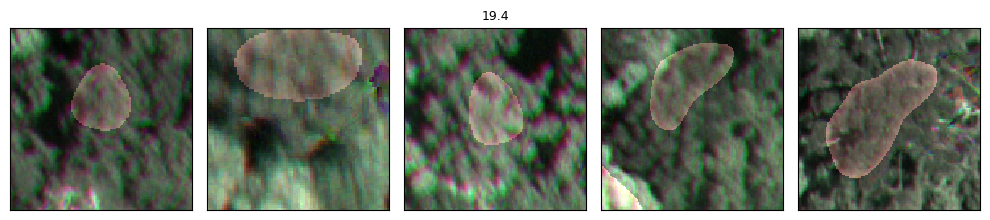

In [10]:
for i, version in enumerate(version_images.keys()):
    fig, ax = plt.subplots(ncols=NUM_IMAGES, sharex=False, sharey=False)

    fig.set_size_inches(10, 5)

    for j, image in enumerate(version_images[version]):
        
        ax[j].imshow(image, interpolation='nearest')
    
    center = len(version_images[version])//2
    
    ax[center].set_title(version, fontsize = 9)

    fig.tight_layout()
    plt.show()
    



# Comparando Segmentação com a base de teste

In [11]:
COMP_TEST_GT = label(TEST_GT_MAP)

## Usando o conjunto de teste que tem alguma que teve alguma área predita

In [27]:
np.random.seed(123)

predicted_images = dict()
test_images = dict()

NUM_IMAGES = 5

for version_folder in version_folders.values:

    iter_folders =  pd.Series(os.listdir(version_folder))

    iter_folders = iter_folders[iter_folders.str.startswith("iter_") & ~ iter_folders.str.endswith("000")]
    
    iter_folders = version_folder + iter_folders
    
    iter_folders = iter_folders.sort_values().tolist()
    
    iter_folders.pop()
    
    version_num = float(version_folder.split("/")[-2].replace("_version_data", ""))
    
    if version_num < 19:
        continue
    


    iter_folder = iter_folders[-1]
    
    
    print(iter_folder)
    
    all_labels = read_tiff(os.path.join(iter_folder, "new_labels", "all_labels_set.tif"))
    

    all_labels_comp = label(all_labels)

    comp_ids = np.unique(all_labels_comp[TEST_GT_MAP > 0])
    
    random_comp = np.random.choice(comp_ids[comp_ids > 0], size = NUM_IMAGES, replace = False)


    predicted_images[version_num] = []
    test_images[version_num] = []


    for comp_id in random_comp:
        # coords = square_comp_coords(comp_id, all_labels_comp)
        coords = square_comp_coords(comp_id, all_labels_comp)

        img_pred = add_mask(all_labels, *coords)
        img_true = add_mask(COMP_TEST_GT, *coords)


        predicted_images[version_num].append(img_pred)
        test_images[version_num].append(img_true)
                

C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.0_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.1_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.2_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.3_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.4_version_data/iter_020


In [28]:
iter_folders[-1]

'C:\\Users\\ziull\\OneDrive\\Documentos\\Estudos\\TCC\\multi-task-fcn/8.1_version_data/iter_001'

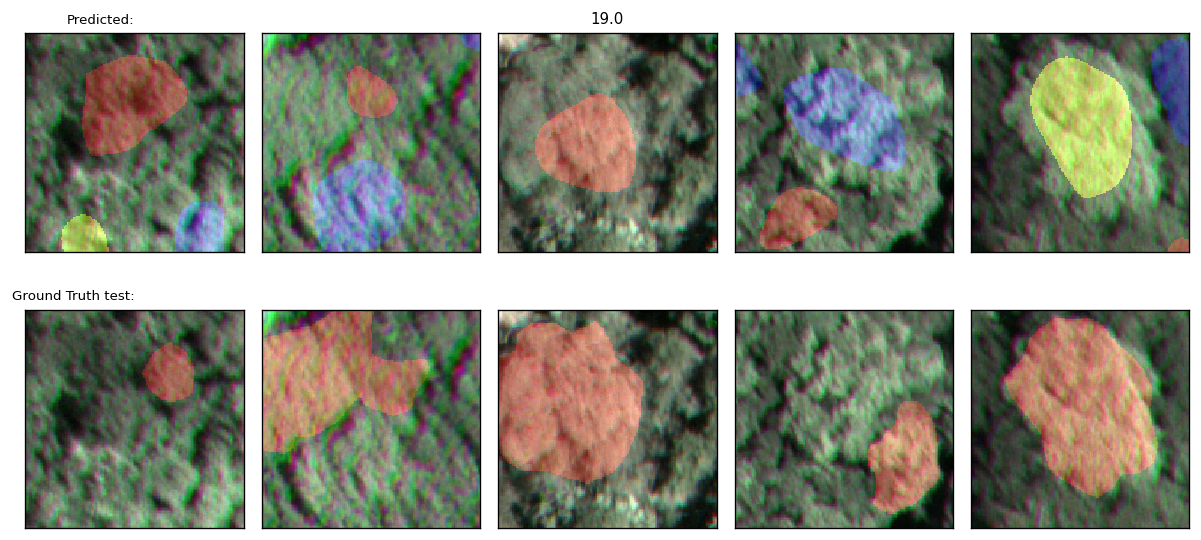

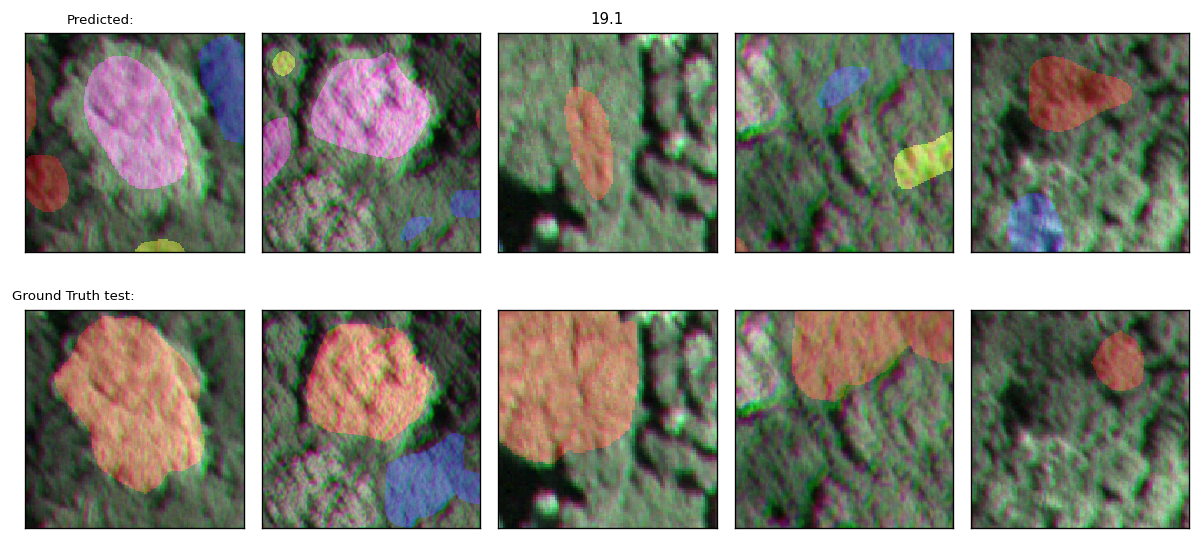

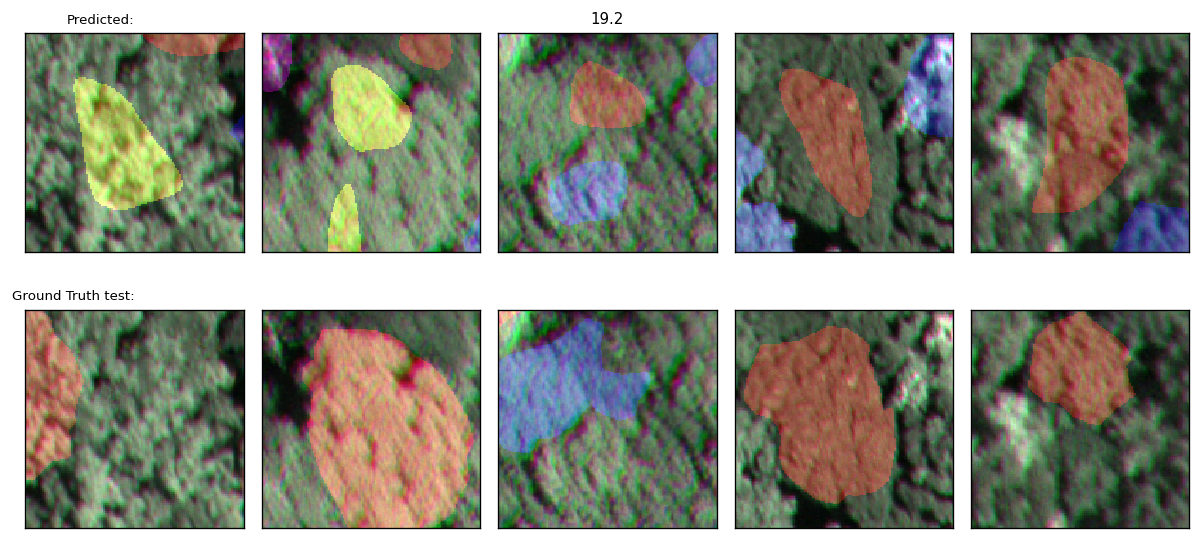

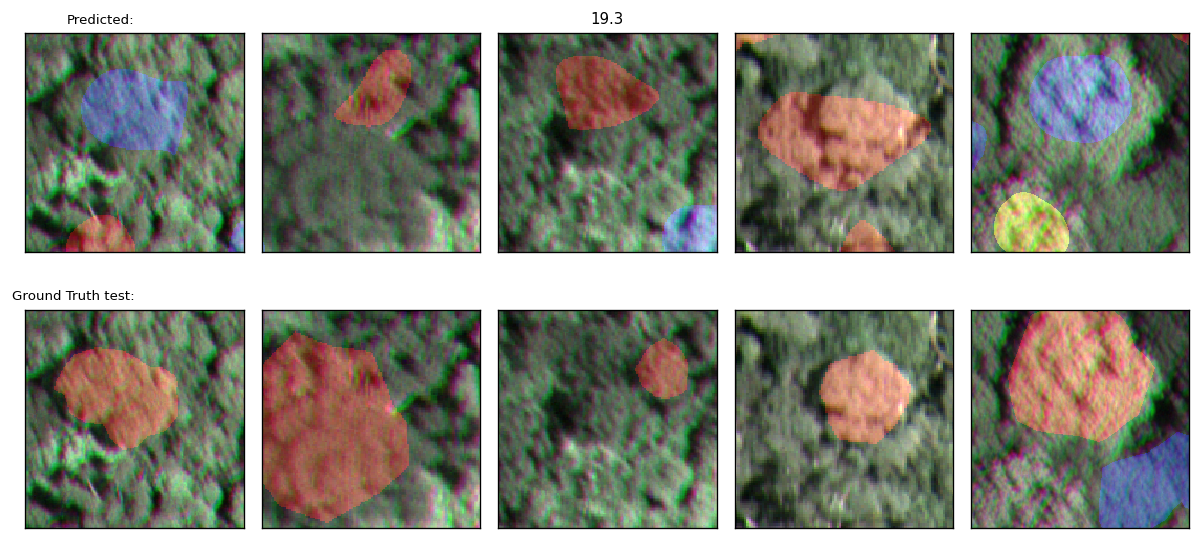

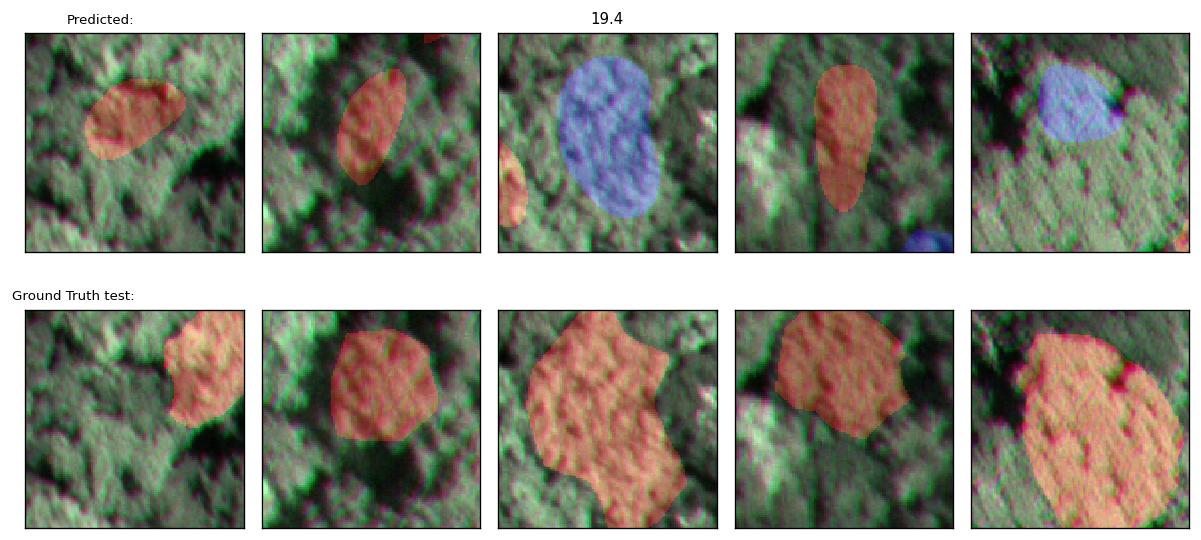

In [29]:

for i, version in enumerate(predicted_images.keys()):
    fig, ax = plt.subplots(ncols=NUM_IMAGES, nrows = 2, sharex=False, sharey=False)

    # fig.set_size_inches(len(version_images), 4)
    fig.set_dpi(120)

    # ax[0].set_title(version, fontsize = 8)
    # plt.text(x=0.5, y=0.5, s= "My title 2 in different size", fontsize=12, ha="center", transform=fig.transFigure)
    fig.set_size_inches(10, 5)

    for j, image in enumerate(predicted_images[version]):
        
        ax[0,j].imshow(image, interpolation='nearest')
    

    for j, image in enumerate(test_images[version]):
        
        ax[1,j].imshow(image, interpolation='nearest')
    
    
    center = len(predicted_images[version])//2
    
    ax[0, center].set_title(version, fontsize = 9)
    
    ax[0, 0].set_title("Predicted:", fontsize = 8, ha = "right")
    ax[1, 0].set_title("Ground Truth test:", fontsize = 8, ha = "right")

    fig.tight_layout()
    plt.show()
    



## Usando conjunto de teste fixo

In [15]:
test_comp_ids = np.unique(COMP_TEST_GT)
test_comp_ids = test_comp_ids[np.nonzero(test_comp_ids)].copy()

NUM_IMAGES = 7

np.random.seed(123)
# Componentes selecionados da base e teste
selected_comp_gt = np.random.choice(test_comp_ids, size = NUM_IMAGES, replace = False)

np.unique(TEST_GT_MAP[np.isin(COMP_TEST_GT, selected_comp_gt)])

array([ 2,  3,  4,  7, 11, 12, 13], dtype=uint8)

In [16]:
np.random.seed(123)

predicted_images = dict()
test_images = dict()


for version_folder in version_folders.values:
    
    version_num = float(version_folder.split("/")[-2].replace("_version_data", ""))
    
    if version_num < 19:
        continue

    
    iter_folders =  pd.Series(os.listdir(version_folder))

    iter_folders = iter_folders[iter_folders.str.startswith("iter_") & ~ iter_folders.str.endswith("000")]
    
    iter_folders = version_folder + iter_folders
    
    iter_folders = iter_folders.sort_values().tolist()
    
    iter_folders.pop()
    
    
    
    # Pegando a quinta ou última iteração
    
    iter_folder = iter_folders[-1]

        
    num_iter = int(iter_folder[-3:])
    
    all_labels = read_tiff(os.path.join(iter_folder, "new_labels", "all_labels_set.tif"))
    

    all_labels_comp = label(all_labels)


    predicted_images[version_num] = []
    test_images[version_num] = []


    for comp_id in selected_comp_gt:
        # coords = square_comp_coords(comp_id, all_labels_comp)
        coords = square_comp_coords(comp_id, COMP_TEST_GT)

        img_pred = add_mask(all_labels, *coords)
        img_true = add_mask(COMP_TEST_GT, *coords)


        predicted_images[version_num].append(img_pred)
        test_images[version_num].append(img_true)
            
        
    print(iter_folder)



C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.0_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.1_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.2_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.3_version_data/iter_020
C:\Users\ziull\OneDrive\Documentos\Estudos\TCC\multi-task-fcn/19.4_version_data/iter_020


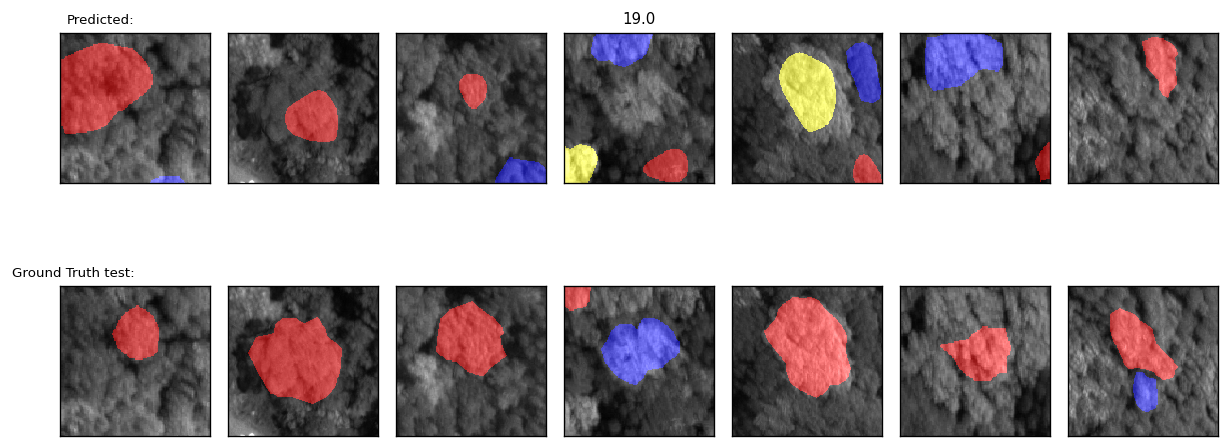

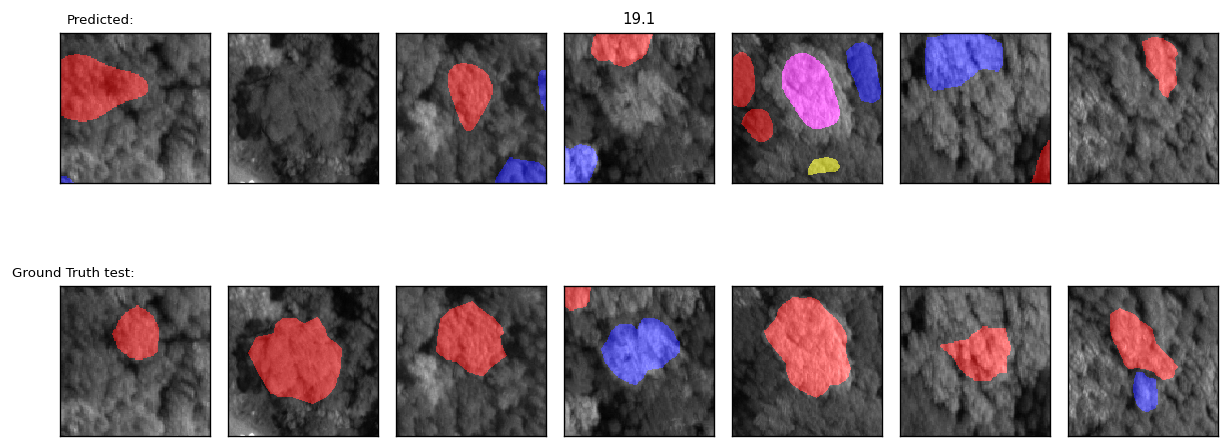

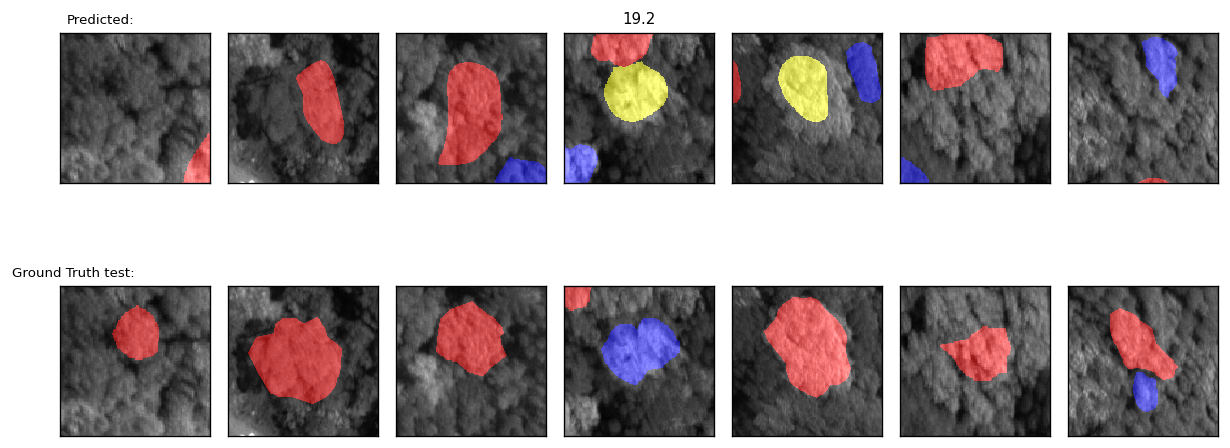

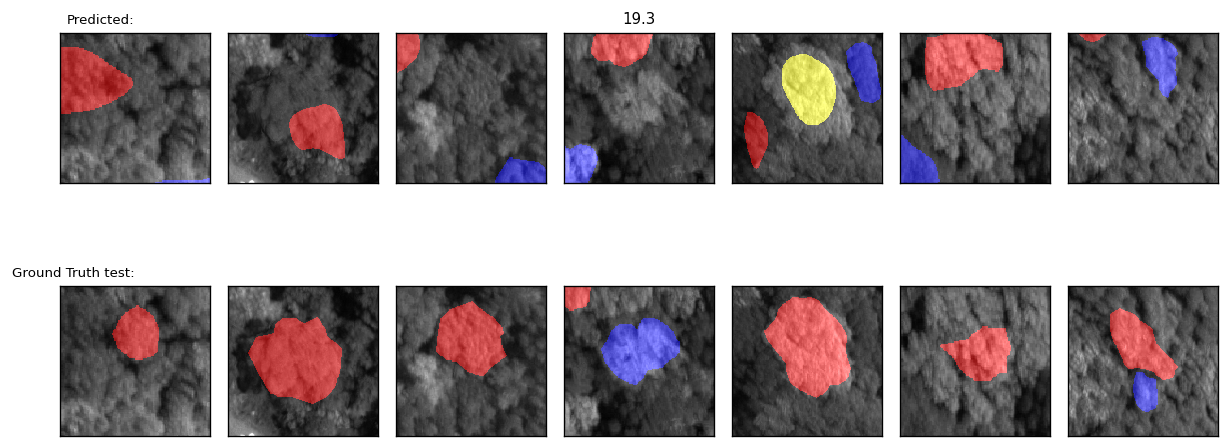

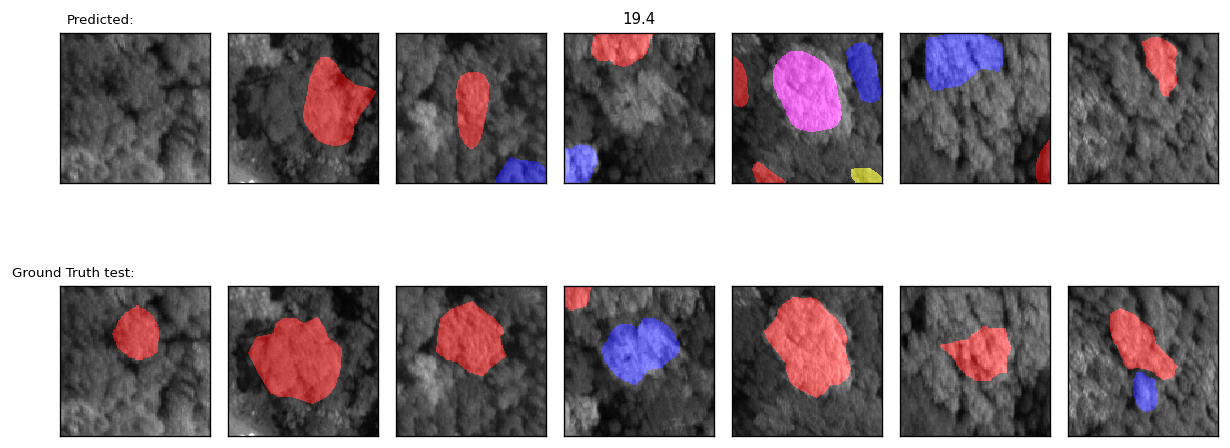

In [19]:

for i, version in enumerate(predicted_images.keys()):
    fig, ax = plt.subplots(ncols=NUM_IMAGES, nrows = 2, sharex=False, sharey=False)

    # fig.set_size_inches(len(version_images), 4)

    # ax[0].set_title(version, fontsize = 8)
    # plt.text(x=0.5, y=0.5, s= "My title 2 in different size", fontsize=12, ha="center", transform=fig.transFigure)
    fig.set_size_inches(10, 5)
    fig.set_dpi(120)

    for j, image in enumerate(predicted_images[version]):
        
        ax[0,j].imshow(image, interpolation='nearest')
    

    for j, image in enumerate(test_images[version]):
        
        ax[1,j].imshow(image, interpolation='nearest')
     
    
    center = len(predicted_images[version])//2
    
    ax[0, center].set_title(version, fontsize = 9)
    
    ax[0, 0].set_title("Predicted:", fontsize = 8, ha = "right")
    ax[1, 0].set_title("Ground Truth test:", fontsize = 8, ha = "right")

    fig.tight_layout()
    plt.show()
    

